# makeLC_calc

In [1]:
# %load OzDES_makeLC_calc.py
# ---------------------------------------------------------- #
# ------------------ OzDES_makeLC_calc.py ------------------ #
# -------- https://github.com/jhoormann/OzDES_makeLC ------- #
# ---------------------------------------------------------- #
# This code was written for the OzDES Reverberation Mapping  #
# Program to create the emission line light curves.  This    #
# code reads in photometric and spectroscopic data.  It will #
# convert the photometric magnitudes into fluxes and extract #
# line fluxes from the spectroscopic data.  In order to      #
# isolate the emission lines the continuum is subtracted by  #
# a local estimation of a linear continuum.  You are also    #
# able to measure the line widths and estimate black hole    #
# mass.  The functions are called in OzDES_makeLC_run.py.    #
# Unless otherwise noted this code was written by            #
# Janie Hoormann.                                            #
# ---------------------------------------------------------- #

# Modified for the WiFeS telescope by Claire Yung            #


from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import interp1d
from scipy.integrate import fixed_quad

In [2]:
# -------------------------------------------------- #
# Modified from a function originally provided by    #
# Anthea King                                        #
# -------------------------------------------------- #
# ----------------- SpectrumCoadd ------------------ #
# -------------------------------------------------- #
# Read in calibrated spectral data assuming data is  #
# in the format provided by OzDES_calibSpec after    #
# coadding.                                          #
# -------------------------------------------------- #
class SpectrumCoadd(object):
    # Spectrum class for latest version of the OzDES pipeline

    def __init__(self, filepath=None):
        assert filepath != None, "No file name is specified."
        self.filepath = filepath
        try:
            self.data = fits.open(filepath)
        except IOError:
            print("Error: file {0} could not be found".format(filepath))
            exit()
        data = fits.open(filepath)
        self.combined = data[1]
        self.combinedVariance = data[2]
        self._wavelength = None
        self._flux = None
        self._variance = None
        self._fluxCoadd = None
        self._varianceCoadd = None
        self._dates = None
        self._runs = None
        self.numEpochs = int((np.size(data) - 3) / 3 +1)
        self.redshift = self.combined.header['z'] ##'z'
        self.RA = self.combined.header['RA']
        self.DEC = self.combined.header['DEC']
        self.wavelength = data[0].data

    @property
    def flux(self):
        if getattr(self, '_flux', None) is None:
            self._flux = np.zeros((len(self.data[0].data), self.numEpochs), dtype=float)
            for i in range(self.numEpochs):
                self._flux[:, i] = self.data[i*3+1].data 
        return self._flux

    @property
    def variance(self):
        if getattr(self, '_variance', None) is None:
            self._variance = np.zeros((len(self.data[0].data), self.numEpochs), dtype=float)
            for i in range(self.numEpochs):
                self._variance[:, i] = self.data[i * 3 + 2].data
        return self._variance

    @property
    def fluxCoadd(self):
        if getattr(self, '_fluxCoadd', None) is None:
            self._fluxCoadd = np.zeros(len(self.data[0].data), dtype=float) 
            self._fluxCoadd[:] = self.data[1].data
        return self._fluxCoadd

    @property
    def varianceCoadd(self):
        if getattr(self, '_varianceCoadd', None) is None:
            self._varianceCoadd = np.zeros(len(self.data[0].data), dtype=float)
            self._varianceCoadd[:] = self.data[2].data
        return self._varianceCoadd

    @property
    def dates(self):
        if getattr(self, '_dates', None) is None:
            self._dates = np.zeros(self.numEpochs, dtype=float)
            for i in range(self.numEpochs):
                self._dates[i] = self.data[i * 3 + 1].header[
                    'UTMJD']+5*i  # this give the average Modified Julian Date (UTC) that observation was taken
        return self._dates

    @property
    def runs(self):
        if getattr(self, '_runs', None) is None:
            self._runs = np.zeros(self.numEpochs, dtype=float)
            for i in range(self.numEpochs):
                self._runs[i] = self.data[i * 3 + 3].header['RUN']  # this give the run number of the observation
        return self._runs

In [3]:
# -------------------------------------------------- #
# ------------------- magToFlux -------------------- #
# -------------------------------------------------- #
# Reads in magnitude, error, and pivot wavelength    #
# and converts to f_lambda in units of ergs/s/cm^2/A #
# -------------------------------------------------- #

def magToFlux(mag, err, pivot):
    flux = (3*pow(10,18)/pow(pivot,2))*pow(10, -(2./5.)*(mag + 48.6))
    flux_err = abs(flux*(-2./5.)*2.30259*err)
    return flux, flux_err

In [4]:
# -------------------------------------------------- #
# ------------------- outputLC --------------------- #
# -------------------------------------------------- #
# Creates an output file with date, flux, error      #
# columns as is expected by lag recovery tools       #
# Javelin and PyCCF.                                 #
# -------------------------------------------------- #
def outputLC(date, flux, error, name, loc, obj_name):

    length = len(date)
    outname = loc + obj_name + "_" + name + ".txt"
    output = open(outname, 'w')

    for i in range(length):
        if np.isnan(flux[i]) == False:
            output.write("%s    %s    %s \n" % (date[i], flux[i], error[i]))
        else:
            # Sometimes the flux ends up as nan, this is generally because the SNR is so bad/the emission line so
            # small that the continuum subtraction makes the line negative.  These are not saved in the data file
            # but a warning is outputted so you can have a look at what the problem is.
            print("-------\n  Houston, we have a problem! " + obj_name + " Night " + str(i) + "\n-------\n ")

    output.close()

    return

In [5]:
# -------------------------------------------------- #
# ------------------ plot_fonts -------------------- #
# -------------------------------------------------- #
# Function to define the font used for plotting.     #
# -------------------------------------------------- #
def plot_fonts(size, color='black', weight='normal', align='bottom'):
    font = {'size': size, 'color': color, 'weight': weight, 'verticalalignment': align}
    return font


# -------------------------------------------------- #
# ------------------ plot_ticks ---------------------#
# -------------------------------------------------- #
# Function to change the plot tick size.             #
# -------------------------------------------------- #
def plot_ticks(ax, size):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(size)
    return


# -------------------------------------------------- #
# ----------------- plot_share_x --------------------#
# -------------------------------------------------- #
# Define figure and axis variables for plot which    #
# shares the x axis for a specified number of plots. #
# -------------------------------------------------- #
def plot_share_x(number, title, xlabel, ylabel, xlim=(0, 0), ylim=(0, 0), asize=22, tsize=22, xdim=10,
                 ydim=10, xtick=5, ytick=5):
    fig, ax_array = plt.subplots(number, sharex=True)
    if number == 1:
        ax_array = [ax_array]
    fig = plt.gcf()
    fig.set_size_inches(xdim, ydim, forward=True)
    fig.subplots_adjust(hspace=0)

    title_font = plot_fonts(tsize, align='bottom')
    x_axis_font = plot_fonts(asize, align='top')
    y_axis_font = plot_fonts(asize, align='bottom')

    for [i, ax] in enumerate(ax_array):
        plot_ticks(ax, asize)
        ax.set_ylabel(ylabel[i], **y_axis_font)
        ax.yaxis.set_major_locator(MaxNLocator(prune='upper'))
        ax.tick_params(axis='y', pad=15)
        if ylim != (0, 0) and ylim[0] < ylim[1]:
            ax.set_ylim(ylim[i])
        if i == 0:
            ax.set_title(title, **title_font)
            ax.tick_params(axis='x', pad=15)
            if xlim != (0, 0) and xlim[0] < xlim[1]:
                ax.set_xlim(xlim)
        if i == number - 1:
            ax.set_xlabel(xlabel, **x_axis_font)
        if ytick is not None:
            ax.yaxis.major.locator.set_params(nbins=ytick)
        if xtick is not None:
            ax.xaxis.major.locator.set_params(nbins=xtick)

    return fig, ax_array

In [6]:
# -------------------------------------------------- #
# ---------------- convertPhotoLC -------------------#
# -------------------------------------------------- #
# Converts photometric light curves from magnitudes  #
# to flux and saves the light curves separately for  #
# each band.                                         #
# -------------------------------------------------- #
def convertPhotoLC(photoName, source, bandName, bandPivot, scale, makeFig, outLoc):
    # Read in the photometric data
    photo = pd.read_csv(photoName, delim_whitespace=True, keep_default_na = False)

    if makeFig == True:
        # Define figure and axis for light curves of all bands
        fig_photo, ax_photo = plot_share_x(len(bandName), source, "Date (MJD)", bandName)

    # Make a light curve for each band
    for b in range(len(bandName)):
        # Create an array for observations of a specified band and sort observations by date
        band_data = photo[photo['FLT'] == bandName[b]].sort_values('MJD') ##instead of 'BAND'
        # Find date, mag, and magerr array for the specified band
        ph_date = np.array(band_data['MJD'])
        ph_mag = np.array(band_data['MAG'])
        ph_magerr = np.array(band_data['MAGERR'])

        # Loop over each epoch and convert magnitude to flux
        ph_flux = np.zeros(len(ph_date))
        ph_fluxerr = np.zeros(len(ph_date))

        for e in range(len(ph_date)):
            ph_flux[e], ph_fluxerr[e] = magToFlux(ph_mag[e], ph_magerr[e], bandPivot[b])

        # Scale the fluxes before they are saved, if you are concerned about remembering the scale factor perhaps
        # included it in the outputted file name.
        ph_flux = ph_flux / scale
        ph_fluxerr = ph_fluxerr / scale

        # Save the data as a light curve with filename outLoc + source + _ + bandName[b] + .txt
        outputLC(ph_date, ph_flux, ph_fluxerr, bandName[b], outLoc, source)

        if makeFig == True:
            # plot the light curve on the subplot defined above.
            ax_photo[b].errorbar(ph_date, ph_flux, yerr=ph_fluxerr, fmt='o', color='black')

    # Once all the light curves are plotted save the figure as outLoc + source + "_photo.png"
    if makeFig == True:
        fig_photo.savefig(outLoc + source + "_photo.png")

    return

In [7]:
# -------------------------------------------------- #
# ------------------ findLines ----------------------#
# -------------------------------------------------- #
# Determines which emission lines are present in the #
# spectrum.  Returns an array of booleans where True #
# means the emission line is present.                #
# -------------------------------------------------- #
def findLines(wavelength, z, lineName, contWinBSMin, contWinBSMax):
    # decide which emission lines are available in the spectrum
    availLines = np.zeros(len(lineName)).astype(bool)

    for l in range(len(lineName)):
        # for a line to be in the spectrum you need to include the continuum subtraction windows as well.  This can
        # be limiting but as we need continuum subtracted spectra it is necessary.
        minWave = min(contWinBSMin[lineName[l]])
        maxWave = max(contWinBSMax[lineName[l]])

        if minWave * (1 + z) > wavelength[0] and maxWave * (1 + z) < wavelength[-1]:
            availLines[l] = True

    return availLines


# -------------------------------------------------- #
# -------------------- findBin ----------------------#
# -------------------------------------------------- #
# Finds the bin of the given vector (wavelength)     #
# where the specified quantity (line) is located.    #
# -------------------------------------------------- #
def findBin(line, wavelength):
    bin = 0
    for i in range(len(wavelength)-1):
        if line >= wavelength[i] and line <= wavelength[i+1]:
            bin = i
            i = len(wavelength)
        if line > wavelength[-1]:
            bin = len(wavelength)-1
            i = len(wavelength)
    return bin


# -------------------------------------------------- #
# ---------------- interpolateVals ------------------#
# -------------------------------------------------- #
# Interpolates a linear line between two points and  #
# propagates the uncertainty.                        #
# -------------------------------------------------- #
def interpolateVals(x, y, s, val):
    # uncertainty is variance

    interp = y[0] + (val - x[0]) * (y[1] - y[0]) / (x[1] - x[0])

    interp_var = s[0] + (s[0] + s[1]) * ((val - x[0]) / (x[1] - x[0])) ** 2.

    return interp, interp_var


# -------------------------------------------------- #
# ------------------ meanUncert ---------------------#
# -------------------------------------------------- #
# Finds the uncertainty corresponding to the mean    #
# of a set of numbers.                               #
# -------------------------------------------------- #
def meanUncert(variance):
    length = len(variance)
    var = 0
    num = 0
    for i in range(length):
        if np.isnan(variance[i]) == False:
            var = var + variance[i]
            num += 1

    sigma2 = (var / (num ** 2))

    return sigma2


# -------------------------------------------------- #
# ---------------- cont_fit_reject ------------------#
# -------------------------------------------------- #
# Interpolate a linear line through the mean of the  #
# continuum subtraction windows to represent the     #
# continuum and subtract this line.  Modifies the    #
# given flux/variance vectors.                       #
# -------------------------------------------------- #
def cont_fit_reject(wavelength, fluxes, variances, minWin, maxWin):

    # Define the wavelength range for the continuum model, between the mean of both windows
    wave = np.array([np.nanmean(minWin), np.nanmean(maxWin)])
    nBins = len(wavelength)

    # Determine how many epochs there are to continuum subtract
    number = int(fluxes.size / nBins)

    for epoch in range(number):
        if number == 1:
            flux = fluxes
            variance = variances
        else:
            flux = fluxes[:, epoch]
            variance = variances[:, epoch]

        # Calculate the average flux at each extreme of the wave vector (ie mean of the continuum subtraction window)
        fvals = np.array([np.nanmean(flux[findBin(minWin[0], wavelength):findBin(minWin[1], wavelength)]),
                          np.nanmean(flux[findBin(maxWin[0], wavelength):findBin(maxWin[1], wavelength)])])

        # Calculate the average uncertainty at each extreme of the wave vector
        svals = np.array([meanUncert(variance[findBin(minWin[0], wavelength):findBin(minWin[1], wavelength)]),
                          meanUncert(variance[findBin(maxWin[0], wavelength):findBin(maxWin[1], wavelength)])])

        cont = np.zeros(nBins)
        contVar = np.zeros(nBins)

        # Find the interpolated linear continuum model
        for i in range(nBins):
            cont[i], contVar[i] = interpolateVals(wave, fvals, svals, wavelength[i])

        # Subtract the continuum from the flux and add the error of the model in quadrature with the spectral error

        if number ==1:
            flux = flux - cont
            variance = variance +contVar
        else:
            flux -= cont
            variance += contVar
        

    return

In [8]:
# -------------------------------------------------- #
# The next three functions are modified from code    #
# provided by Dale Mudd                              #
# -------------------------------------------------- #
# ------------------ filterCurve ------------------- #
# -------------------------------------------------- #
# creates a class to hold the transmission function  #
# for each band.                                     #
# -------------------------------------------------- #
class filterCurve:
    """A filter"""

    def __init__(self):
        self.wave = np.array([], 'float')
        self.trans = np.array([], 'float')
        return

    def read(self, file):
        # DES filter curves express the wavelengths in nms
        if 'DES' in file:
            factor = 10.
        else:
            factor = 1.
        file = open(file, 'r')
        for line in file.readlines():
            if line[0] != '#':
                entries = line.split()
                self.wave = np.append(self.wave, float(entries[0]))
                self.trans = np.append(self.trans, float(entries[1]))
        file.close()
        # We use Angstroms for the wavelength in the filter transmission file
        self.wave = self.wave * factor
        return


# -------------------------------------------------- #
# ---------------- readFilterCurve ----------------- #
# -------------------------------------------------- #
# Reads in the filter curves and stores it as the    #
# filter curve class.                                #
# -------------------------------------------------- #
def readFilterCurves(bands, filters):

    filterCurves = {}
    for f in bands:
        filterCurves[f] = filterCurve()
        filterCurves[f].read(filters[f])

    return filterCurves


# -------------------------------------------------- #
# ----------------- computeABmag ------------------- #
# -------------------------------------------------- #
# computes the AB magnitude for given transmission   #
# functions and spectrum (f_lambda).  Returns the    #
# magnitude and variance.                            #
# -------------------------------------------------- #
def computeABmag(trans_flux, trans_wave, tmp_wave, tmp_flux, tmp_var):
    # Takes and returns variance
    # trans_ : transmission function data
    # tmp_ : spectral data

    # trans/tmp not necessarily defined over the same wavelength range
    # first determine the wavelength range over which both are defined
    minV = min(trans_wave)
    if minV < min(tmp_wave):
        minV = min(tmp_wave)
    maxV = max(trans_wave)
    if maxV > max(trans_wave):
        maxV = max(trans_wave)

    interp_wave = []
    tmp_flux2 = []
    tmp_var2 = []

    # Make new vectors for the flux just using that range (assuming spectral binning)

    for i in range(len(tmp_wave)):
        if minV < tmp_wave[i] < maxV:
            interp_wave.append(tmp_wave[i])
            tmp_flux2.append(tmp_flux[i])
            tmp_var2.append(tmp_var[i])

    # interpolate the transmission function onto this range
    # the transmission function is interpolated as it is generally much smoother than the spectral data
    trans_flux2 = interp1d(trans_wave, trans_flux)(interp_wave)

    # And now calculate the magnitude and uncertainty

    c = 2.992792e18  # Angstrom/s
    Num = np.nansum(tmp_flux2 * trans_flux2 * interp_wave)
    Num_var = np.nansum(tmp_var2 * (trans_flux2 * interp_wave) ** 2)
    Den = np.nansum(trans_flux2 / interp_wave)

    with np.errstate(divide='raise'):
        try:
            magAB = -2.5 * np.log10(Num / Den / c) - 48.60
            magABvar = 1.17882 * Num_var / (Num ** 2)
        except FloatingPointError:
            magAB = 99.
            magABvar = 99.

    return magAB, magABvar


# --------------------------------------------------- #
# --------------- uncertainty_cont ------------------ #
# --------------------------------------------------- #
# This function finds the uncertainty in line flux    #
# and width measurements.  For line flux you can      #
# input a range of potential continuum windows and    #
# it will randomly pick regions to use for continuum  #
# subtraction. You can also input a region over which #
#  to randomly choose the integration window.  These  #
# all also include flux randomization in order to     #
# consider the effect of the variance spectrum.       #
# You can also look at the effect flux randomization  #
# has on the line width measurements FWHM and         #
# velocity dispersion.  You can also specify to look  #
# at the RMS spectrum (flag='rms') for the line width #
# measurements, the default is to look at the provided#
# spectrum as is.  The error is calculated through    #
# bootstrap resampling using strapNum iterations.     #
# The standard deviation of the calculated quantity   #
# is then the associated error.                       #
# --------------------------------------------------- #
def uncertainty_cont(wavelength, flux, variance, strapNum, z, line, pivotLC, winLimMin, winLimMax, winsize, scale,
                     calc='cont', flag='mean', res=0):

    # calc = cont -> continuum subtraction
    # calc = win -> integration window
    # calc = fwhm -> FWHM line width: can specify flag=rms
    # calc = sigma -> line velocity dispersion: can specify flag=rms

    # Performs bootstrap resampling in the range of potentially clean continuum to determine
    # uncertainties on the flux measurement

    # Continuum window in Angstroms - will be scaled according to redshift

    # Winsize means the continuum subtraction windows are all the same size, just the locations shift
    winsize = winsize/(1+z)

    lineMin = line[0]
    lineMax = line[1]

    # Option for potentially clean continuum region pass in bootstrap

    # Calculate the width of the bootstrapping region on each side of the line
    lowW = (winLimMin[1]-winLimMin[0])/(1+z)
    highW = (winLimMax[1]-winLimMax[0])/(1+z)

    # Check edge conditions: if the bootstraping region goes outside the region of the spectrograph use the spectrograph
    # bounds as the edges
    if winLimMin[0] < wavelength[0]:
        winLimMin[0] = wavelength[0]
        winLimMin[1] = (winLimMin[0] / (1 + z) + lowW) * (1 + z)
    if winLimMin[1] > wavelength[line[0]]:
        winLimMin[1] = wavelength[line[0]]
    if winLimMax[1] > wavelength[-1]:
        winLimMax[1] = wavelength[-1]
        winLimMax[0] = (winLimMax[1] / (1 + z) - highW) * (1 + z)
    if winLimMax[0] < wavelength[line[1]]:
        winLimMax[0] = wavelength[line[1]]

    # Wavelengths to choose in each window in steps of 0.5A
    winMinVect = np.arange(winLimMin[0], winLimMin[1] - (winsize - 0.5) * (1 + z), 0.5 * (1 + z))
    winMaxVect = np.arange(winLimMax[0], winLimMax[1] - (winsize - 0.5) * (1 + z), 0.5 * (1 + z))

    # Array of random continuum window starting points
    randVectMin = len(winMinVect) * np.random.rand(strapNum)
    randVectMin = randVectMin.astype(int)

    randVectMax = len(winMaxVect) * np.random.rand(strapNum)
    randVectMax = randVectMax.astype(int)

    # An array of values obtained through bootstrapping to determine uncertainties
    vals = np.zeros(strapNum)

    for i in range(strapNum):

        if calc == 'win':
            # subtracts from standard continuum but changes integration window, in this case feed in potential
            # integration windows instead of bootstrapping regions

            lineMinNew = findBin(winMinVect[randVectMin[i]], wavelength)
            lineMaxNew = findBin(winMaxVect[randVectMax[i]], wavelength)

            # Performs flux resampling to account for variance spectrum.  Flux values shifted by Gaussian scaled by
            # variance
            varC = np.copy(variance)
            fluxC = flux + np.random.normal(size=flux.shape) * (variance ** 0.5)

            # Continuum Subtract this new vector
            cont_fit_reject(wavelength, fluxC, varC, winLimMin, winLimMax)

            # Calculate the flux
            lc_mag, lc_mag_err = computeABmag(np.ones(len(wavelength[lineMinNew:lineMaxNew])),
                                              wavelength[lineMinNew:lineMaxNew], wavelength[lineMinNew:lineMaxNew],
                                              fluxC[lineMinNew:lineMaxNew]*scale, varC[lineMinNew:lineMaxNew]*
                                              pow(scale,2))

            vals[i], lc_mag_err = magToFlux(lc_mag, lc_mag_err**0.5, pivotLC)

        if calc == "cont":
            # changes cont region
            minWin = [winMinVect[randVectMin[i]], winMinVect[randVectMin[i]] + winsize * (1 + z)]
            maxWin = [winMaxVect[randVectMax[i]], winMaxVect[randVectMax[i]] + winsize * (1 + z)]

            # Performs flux resampling to account for variance spectrum.  Flux values shifted by Gaussian scaled by
            # variance
            varC = np.copy(variance)
            fluxC = flux + np.random.normal(size=flux.shape) * (variance ** 0.5)

            # Continuum Subtract this new vector
            cont_fit_reject(wavelength, fluxC, varC, minWin, maxWin)

            # Calculate the flux
            lc_mag, lc_mag_err = computeABmag(np.ones(len(wavelength[lineMin:lineMax])),wavelength[lineMin:lineMax],
                                              wavelength[lineMin:lineMax], fluxC[lineMin:lineMax]*scale,
                                              varC[lineMin:lineMax]*pow(scale, 2))

            vals[i], lc_mag_err = magToFlux(lc_mag, lc_mag_err**0.5, pivotLC)

        if calc == "fwhm":
            # Determine uncertainty in FWHM line measurement
            # do flux randomization and continuum subtraction
            varC = np.copy(variance)
            fluxC = flux + np.random.normal(size=flux.shape) * (variance ** 0.5)
            cont_fit_reject(wavelength, fluxC, varC, winLimMin, winLimMax)

            if flag == 'rms':
                # first calculate the RMS spectrum if requested
                fluxC, varC = rmsSpec(fluxC, varC)

            vals[i] = fwhm(wavelength[lineMin:lineMax], fluxC[lineMin:lineMax], res)

        if calc == "sigma":
            # Determine uncertainty in velocity dispersion measurement
            # do flux randomization and continuum subtraction
            varC = np.copy(variance)
            fluxC = flux + np.random.normal(size=flux.shape) * (variance ** 0.5)
            cont_fit_reject(wavelength, fluxC, varC, winLimMin, winLimMax)

            if flag == 'rms':
                # first calculate the RMS spectrum if requested
                fluxC, varC = rmsSpec(fluxC, varC)
            vals[i] = lineVar(wavelength[lineMin:lineMax], fluxC[lineMin:lineMax], res)

    stddev_bs = np.nanstd(vals)
    return stddev_bs

In [9]:
# --------------------------------------------------- #
# ----------------------- fwhm ---------------------- #
# --------------------------------------------------- #
# Takes an input spectrum and calculate the FWHM of   #
# the provided emission line.  It will search over    #
# the entire provided wavelength window so just       #
# include the relevant region of the spectrum.        #
# --------------------------------------------------- #
def fwhm(wave, flux, res):
    # First I am smoothing the spectrum
    exponential_smooth(flux)

    # Find the half maximum
    peak = max(flux)
    valley = min(flux)
    peakLoc = wave[np.where(flux == peak)[0][0]]
    peakLocB = findBin(peakLoc, wave)
    hm = (peak-valley) / 2 + valley

    leftUp = wave[0]
    leftDown = wave[peakLocB]
    rightUp = wave[-1]
    rightDown = wave[peakLocB]

    # First search for the half max to the left of the line
    for i in range(peakLocB):
        # First search going up the line
        if flux[i] < hm < flux[i+1]:
            leftUp = (wave[i] + wave[i+1])/2
        # Then going down the line
        if flux[peakLocB-i-1] < hm < flux[peakLocB-i]:
            leftDown = (wave[peakLocB-i-1] + wave[peakLocB-i])/2

    # Then take the average which will account for any double peaks/noise in the spectrum
    left = (leftUp + leftDown)/2

    # And now to the right
    maxSize = len(wave) - 1

    for i in range(maxSize - peakLocB):
        # Go up
        if flux[peakLocB + i + 1] < hm < flux[peakLocB + i]:
            rightDown = (wave[peakLocB + i] + wave[peakLocB + i + 1])/2
        # Go down
        if flux[maxSize-i] < hm < flux[maxSize-i-1]:
            rightUp = (wave[maxSize-i] + wave[maxSize-i-1])/2

    right = (rightUp + rightDown)/2

    # Now calculate the velocity

    # km/s
    c = 299792.458

    widthObs = (right-left)
    widthT = pow(widthObs**2 - res**2,0.5)/2

    zLeft = -widthT/peakLoc
    zRight = widthT/peakLoc

    zComb = (1+zRight)/(1+zLeft)-1

    vel = c*((1+zComb)**2-1)/((1+zComb)**2+1)

    return vel

In [10]:
# --------------------------------------------------- #
# ---------------------- lineVar -------------------- #
# --------------------------------------------------- #
# Takes an input spectrum and calculate the velocity  #
# dispersion of the emission line.  It will search    #
# over the entire provided wavelength window so just  #
# include the relevant region of the spectrum.        #
# --------------------------------------------------- #
def lineVar(wave, flux, res):
    length = len(wave)

    peak = max(flux)
    peakLoc = wave[np.where(flux == peak)[0][0]]

    # Calculate velocity dispersion following equation written in Peterson 2004, the three following constants
    # correspond to the main terms in that equation.

    Pdl = 0
    lPdl = 0
    l2Pdl = 0

    for i in range(length):
        Pdl += flux[i]

        lPdl += flux[i] * wave[i]

        l2Pdl += flux[i] * pow(wave[i], 2)

    lambda0 = lPdl / Pdl

    lambda2 = l2Pdl / Pdl

    lambda02 = pow(lambda0, 2)

    linevar = lambda2 - lambda02

    sigma = linevar ** 0.5

    c = 299792.458

    sigmaT = pow(sigma**2 - res**2, 0.5)

    left = peakLoc - sigmaT / 2
    right = peakLoc + sigmaT / 2

    zLeft = (left - peakLoc) / peakLoc
    zRight = (right - peakLoc) / peakLoc


    #redshift from lambda_l to lambda_r
    zComb = (1 + zRight) / (1 + zLeft) - 1

    vel = c * ((1 + zComb) ** 2 - 1) / ((1 + zComb) ** 2 + 1)

    return vel

In [11]:
# --------------------------------------------------- #
# --------------- exponential_smooth ---------------- #
# --------------------------------------------------- #
# Function to apply an exponential smoothing kernel   #
# to the data.  Written by Harry Hobson.              #
# --------------------------------------------------- #
def exponential_smooth(fluxes):

    number = int(fluxes.size/fluxes.shape[0])

    search_pixels = 5
    decay = 0.9

    window = np.arange(-search_pixels, search_pixels + 1)
    weights = decay ** np.abs(window)
    weights /= np.sum(weights)

    if (number == 1):
        flux = fluxes[:]
        flux[:] = np.convolve(flux, weights, mode='same')
    else:
        for epoch in range(fluxes.shape[1]):
            flux = fluxes[:, epoch]
            flux[:] = np.convolve(flux, weights, mode='same')


# --------------------------------------------------- #
# -------------------- meanSpec --------------------- #
# --------------------------------------------------- #
# Calculates the mean of multiple spectra as well as  #
# the corresponding variance spectrum.                #
# --------------------------------------------------- #
def meanSpec(flux, variance):

    length = len(flux[:,0])

    meanFlux = np.zeros(length)
    meanVar = np.zeros(length)

    for i in range(length):
        meanFlux[i] = np.nanmean(flux[i,:])
        meanVar[i] = np.nanmean(variance[i,:])

    return meanFlux, meanVar


# --------------------------------------------------- #
# -------------------- rmsSpec ---------------------- #
# --------------------------------------------------- #
# Calculates the RMS of the inputted spectra.  Will   #
# expect fluxes in [wavelength, epoch] format.  An    #
# exponential smoothing function is applied to the    #
# data as a first and last step to mitigate some of   #
# the noise.                                          #
# --------------------------------------------------- #
def rmsSpec(flux, variance):
    # smooth the input spectra
    exponential_smooth(flux)

    length = len(flux[:, 0])
    epochs = len(flux[0, :])

    # Calculate the RMS spectrum, variance propagated through but not used later
    mean, meanVar = meanSpec(flux, variance)
    rms = np.zeros(length)
    rmsVar = np.zeros(length)
    rmsVar2 = np.zeros(length)

    for b in range(length):
        for e in range(epochs):
            rms[b] += (flux[b, e] - mean[b]) ** 2
            rmsVar2[b] += 4 * rms[b] * (variance[b, e] + meanVar[b])
        rms[b] = (rms[b] / (epochs - 1)) ** 0.5
        rmsVar2[b] = rmsVar2[b] / ((epochs - 1) ** 2)
        rmsVar[b] = rmsVar2[b] * (0.5 / rms[b]) ** 2

    # smooth the final RMS spectrum
    exponential_smooth(rms)

    return rms, rmsVar


# -------------------------------------------------- #
# -------------------- lineLC ---------------------- #
# -------------------------------------------------- #
# Create emission line light curves by integrating   #
# the emission lines after local continuum           #
# subtraction.  The uncertainties due to the variance#
# of the spectrum and the continuum subtraction is   #
# performed through bootstrap resampling.  This is   #
# done for every emission line from the provided list#
# that is present in the spectrum.                   #
# -------------------------------------------------- #
def lineLC(dates, lineName, availLines, lineInt, contWinMin, contWinMax, contWinBSMin, contWinBSMax, wavelength,
           origFluxes, origVariances, fluxCoadd, numEpochs, scale, z, strapNum, outLoc, source, makeFig, makeFigEpoch):

    if makeFig == True:
        # Define figure and axis for light curves of all available emission lines
        lineAxis = [lineName[i] for i in range(len(lineName)) if availLines[i] == True]
        fig_spec, ax_spec = plot_share_x(len(lineAxis), source, "Date (MJD)", lineAxis)
    for l in range(len(lineName)):
        if availLines[l] == True:
            line = lineName[l]

            # Copy the flux/variance vectors so you have an uncontinuum subtracted version to use for other lines
            fluxes = np.copy(origFluxes)
            variances = np.copy(origVariances)

            # define some variables for line/continuum windows in observed frame
            contMin = np.array(contWinMin[line]) * (1 + z)
            contMax = np.array(contWinMax[line]) * (1 + z)
            contMinBS = np.array(contWinBSMin[line]) * (1 + z)
            contMaxBS = np.array(contWinBSMax[line]) * (1 + z)

            # similar for the line integration window but I want the wavelength bin number, not just the wavelength
            lineMin = findBin(lineInt[line][0] * (1 + z), wavelength)
            lineMax = findBin(lineInt[line][1] * (1 + z), wavelength)

            # Perform the continuum subtraction
            cont_fit_reject(wavelength, fluxes, variances, contMin, contMax)

            lc_mag = np.zeros(numEpochs)
            lc_mag_sigma = np.zeros(numEpochs)
            lc_flux = np.zeros(numEpochs)
            lc_flux_sigma = np.zeros(numEpochs)
            total_error = np.zeros(numEpochs)

            # Calculate the pivot wavelength associated with each line window
            pivotLC = pow(np.nansum(wavelength[lineMin:lineMax]) / np.nansum(1 / wavelength[lineMin:lineMax]), 0.5)

            # Calculate magnitudes and fluxes for each line
            for epoch in range(numEpochs):
                # first calculate magnitudes, save these if you want to compare this instead of fluxes
                # Here the transmission function is 1 for all wavelengths within the integration window.
                lc_mag[epoch], lc_mag_sigma[epoch] = computeABmag(np.ones(len(wavelength[lineMin:lineMax])),
                                                                  wavelength[lineMin:lineMax],
                                                                  wavelength[lineMin:lineMax],
                                                                  fluxes[lineMin:lineMax, epoch] * scale,
                                                                  variances[lineMin:lineMax, epoch] * pow(scale, 2))
                # Now convert to flux, this is what is saved.  Note: all fluxes here are actually flux densities
                # This uncertainty just considers the variance spectrum, we will take everything in the next step
                lc_flux[epoch], lc_flux_sigma[epoch] = magToFlux(lc_mag[epoch], lc_mag_sigma[epoch] ** 0.5, pivotLC)
                total_error[epoch] = uncertainty_cont(wavelength, origFluxes[:, epoch], origVariances[:, epoch],
                                                      strapNum, z, [lineMin, lineMax], pivotLC, contMinBS,
                                                      contMaxBS, contMin[1] - contMin[0], scale)

                if makeFigEpoch == True:
                    # Save figures showing spectrum before/after continuum subtraction for each epoch and line
                    fig_epoch, ax_epoch = plot_share_x(2, source + " epoch " + str(epoch), "Wavelength ($\AA$)",
                                                       ["Before", " After"], [wavelength[0], wavelength[-1]])
                    for p in range(2):
                        ax_epoch[p].axvspan(contMinBS[0], contMinBS[1], color='mediumblue', alpha=0.3)
                        ax_epoch[p].axvspan(contMaxBS[0], contMaxBS[1], color='mediumblue', alpha=0.3)
                        ax_epoch[p].axvspan(contMin[0], contMin[1], color='mediumblue', alpha=0.5)
                        ax_epoch[p].axvspan(contMax[0], contMax[1], color='mediumblue', alpha=0.5)
                        ax_epoch[p].axvspan(wavelength[lineMin], wavelength[lineMax], color='forestgreen', alpha=0.3)
                    ax_epoch[0].plot(wavelength, origFluxes[:, epoch], color='black')
                    ax_epoch[1].plot(wavelength, fluxes[:, epoch], color='black')
                    fig_epoch.savefig(outLoc + source + "_" + lineName[l] + "_epoch_" + str(epoch) + ".png")
                    plt.close(fig_epoch)

            # Scale the line fluxes as with the photometry
            lc_flux = lc_flux / scale
            total_error = total_error / scale

            # Save the data as a light curve with filename outLoc + source + _ + line + .txt
            outputLC(dates, lc_flux, total_error, line, outLoc, source)

            if makeFig == True:
                # plot the light curve on the subplot defined above. First get the index for the axis associated with
                # the line being analyzed.
                lbin = lineAxis.index(line)

                ax_spec[lbin].errorbar(dates, lc_flux, yerr=total_error, fmt='o', color='black')

                # make a plot to show the continuum subtraction regions on the coadded spectrum
                fig_coadd, ax_coadd = plot_share_x(1, source, "Wavelength ($\AA$)", ["Total Coadded Flux (" + str(scale)
                                                                                     + " erg/s/cm$^2$/$\AA$)"],
                                                   [wavelength[0], wavelength[-1]])
                ax_coadd[0].axvspan(contMinBS[0], contMinBS[1], color='mediumblue', alpha=0.3)
                ax_coadd[0].axvspan(contMaxBS[0], contMaxBS[1], color='mediumblue', alpha=0.3)
                ax_coadd[0].axvspan(contMin[0], contMin[1], color='mediumblue', alpha=0.5)
                ax_coadd[0].axvspan(contMax[0], contMax[1], color='mediumblue', alpha=0.5)
                ax_coadd[0].axvspan(wavelength[lineMin], wavelength[lineMax], color='forestgreen', alpha=0.3)
                ax_coadd[0].plot(wavelength, fluxCoadd, color='black')
                fig_coadd.savefig(outLoc + source + "_" + lineName[l] + "_coadd.png")
                plt.close(fig_coadd)
                

    # Once all the light curves are plotted save the figure as outLoc + source + "_spec.png"
    if makeFig == True:
        fig_spec.savefig(outLoc + source + "_spec.png")

    return


# -------------------------------------------------- #
# ----------------- makeFigSingle ------------------ #
# -------------------------------------------------- #
# -------------------------------------------------- #
# A function that defines a figure with legible axis #
# labels.                                            #
# -------------------------------------------------- #
font = {'size': '20', 'color': 'black', 'weight': 'normal'}


def makeFigSingle(title, xlabel, ylabel, xlim=[0, 0], ylim=[0, 0]):
    fig = plt.gcf()
    fig.set_size_inches(10, 10, forward=True)

    ax = fig.add_subplot(111)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

    ax.set_ylabel(ylabel, **font)
    if ylim != [0, 0] and ylim[0] < ylim[1]:
        ax.set_ylim(ylim)

    ax.set_xlabel(xlabel, **font)
    if xlim != [0, 0] and xlim[0] < xlim[1]:
        ax.set_xlim(xlim)

    ax.set_title(title, **font)

    return fig, ax


# -------------------------------------------------- #
# ------------------ makePhotoLC --------------------#
# -------------------------------------------------- #
# Makes light curves by applying photometric filters #
# to a series of spectral data.  The data is saved   #
# as fluxes.                                         #
# -------------------------------------------------- #
def makePhotoLC(dates, bandName, bandPivot, filters, wavelength, origFluxes, origVariances, numEpochs, scale, outLoc,
                source, makeFig):

    filterCurves = readFilterCurves(bandName, filters)

    if makeFig == True:
        # Define figure and axis for light curves of all available emission lines
        fig_phot, ax_phot = plot_share_x(len(bandName), source, "Date (MJD)", bandName)

    for b in range(len(bandName)):
        mags = np.zeros(numEpochs)
        mags_var = np.zeros(numEpochs)
        flux = np.zeros(numEpochs)
        flux_err = np.zeros(numEpochs)

        for e in range(numEpochs):
            # Calculate the magntiude given the transmission function provided
            mags[e], mags_var[e] = computeABmag(filterCurves[bandName[b]].trans, filterCurves[bandName[b]].wave,
                                                wavelength, origFluxes[:, e] * scale,
                                                origVariances[:, e] * pow(scale, 2))
            # Then convert to fluxes
            flux[e], flux_err[e] = magToFlux(mags[e], mags_var[e] ** 0.5, bandPivot[b])

        # Scale the  fluxes
        flux = flux / scale
        flux_err = flux_err / scale

        # Save the data as a light curve with filename outLoc + source + _ + calc_bandName + .txt
        outputLC(dates, flux, flux_err, 'calc_' + bandName[b], outLoc, source)

        if makeFig == True:
            # plot the light curve on the subplot defined above.
            ax_phot[b].errorbar(dates, flux, yerr=flux_err, fmt='o', color='black')

    # Once all the light curves are plotted save the figure as outLoc + source + "_makePhot.png"
    if makeFig == True:
        fig_phot.savefig(outLoc + source + "_makePhot.png")

    return


# -------------------------------------------------- #
# ------------------- calcWidth ---------------------#
# -------------------------------------------------- #
# Calculates emission line width (FWHM and velocity  #
# dispersion) using the mean and RMS spectra.  If    #
# possible calculates the BH mass using the R-L      #
# relationship.  The data is saved to a text file.   #
# -------------------------------------------------- #
def calcWidth(wavelength, lineName, lineLoc, availLines, lineInt, lumLoc, contWinMin, contWinMax, contWinBSMin,
              contWinBSMax, origFluxes, origVariances, origFluxCoadd, origVarCoadd, z, strapNum, scale, outLoc, source,
              makeFig, calcBH):

    # open a file to save the data to - outLoc + source + _vel.txt
    out = open(outLoc + source + "_vel_and_mass.txt", 'w')

    # Type (Mean/RMS), Measure (FWHM, Vel Disp)
    out.write("Line Type Measure Vel Vel_Err Mass Lag Lag_Err_Min Lag_Err_Max Mass_Err_Min, Mass_Err_Max\n")

    # Convert wavelength vector to rest frame
    wave = wavelength/(1+z)
    for l in range(len(lineName)):
        if availLines[l] == True:
            line = lineName[l]

            # If calcBH == True estimate BH mass from the R-L relationship.  Here I will calculate the lag.  If you want
            # to use the measured lag feed that in here.  If the luminosity needed isn't in the spectroscopic window
            # I will just give nan for the black hole mass.  The luminosity is determined from the coadded flux

            if calcBH == True:
                lum, lumerr = luminosity(wavelength, origFluxCoadd, origVarCoadd, z, lumLoc[l]*(1+z), strapNum, scale)
                if np.isnan(lum) == True:
                    lag = np.nan
                    lag_err_min = np.nan
                    lag_err_max = np.nan
                elif line == 'CIV':
                    lag, lag_err_max, lag_err_min = RL_CIV(lum, lumerr)
                elif line == 'MgII':
                    lag, lag_err_max, lag_err_min = RL_MgII(lum, lumerr)
                elif line == 'Hbeta':
                    lag, lag_err_max, lag_err_min = RL_Hbeta(lum, lumerr)
            else:
                lag = np.nan
                lag_err_min = np.nan
                lag_err_max = np.nan

            # Calculate the resolution of the spectrograph at the specified wavelength
            res = findRes(lineLoc[l], z)

            # define some variables for line/continuum windows in rest frame
            contMin = np.array(contWinMin[line])
            contMax = np.array(contWinMax[line])
            contMinBS = np.array(contWinBSMin[line])
            contMaxBS = np.array(contWinBSMax[line])

            # similar for the line integration window but I want the wavelength bin number, not just the wavelength
            lineMin = findBin(lineInt[line][0], wave)
            lineMax = findBin(lineInt[line][1], wave)

            fluxes = np.copy(origFluxes)
            variances = np.copy(origVariances)

            fluxCoadd = np.copy(origFluxCoadd)
            varCoadd = np.copy(origVarCoadd)

            # Perform the continuum subtraction on epochs and coadd
            cont_fit_reject(wave, fluxes, variances, contMin, contMax)
            cont_fit_reject(wave, fluxCoadd, varCoadd, contMin, contMax)

            # First look at the mean spectrum, let's smooth it
            # FWHM
            vel_mean_fwhm = fwhm(wave[lineMin:lineMax], fluxCoadd[lineMin:lineMax], res)
            err_mean_fwhm = uncertainty_cont(wave, origFluxCoadd, origVarCoadd, strapNum, 0, [lineMin, lineMax], 0,
                                             contMinBS, contMaxBS, contMin[1] - contMin[0], scale, calc='fwhm',
                                             flag='mean', res=res)


            # Sigma
            vel_mean_sigma = lineVar(wave[lineMin:lineMax], fluxCoadd[lineMin:lineMax], res)
            err_mean_sigma = uncertainty_cont(wave, origFluxCoadd, origVarCoadd, strapNum, 0, [lineMin, lineMax], 0,
                                              contMinBS, contMaxBS, contMin[1] - contMin[0], scale, calc='sigma',
                                              flag='mean', res=res)

            # Now look at the RMS spectrum
            rms, rms_var = rmsSpec(fluxes, variances)
            vel_rms_fwhm = fwhm(wave[lineMin:lineMax], rms[lineMin:lineMax], res)
            err_rms_fwhm = uncertainty_cont(wave, origFluxes, origVariances, strapNum, 0, [lineMin, lineMax], 0,
                                            contMinBS, contMaxBS, contMin[1] - contMin[0], scale, calc='fwhm',
                                            flag='rms', res=res)

            # Sigma
            vel_rms_sigma = fwhm(wave[lineMin:lineMax], rms[lineMin:lineMax], res)
            err_rms_sigma = uncertainty_cont(wave, origFluxes, origVariances, strapNum, 0, [lineMin, lineMax], 0,
                                             contMinBS, contMaxBS, contMin[1] - contMin[0], scale, calc='sigma',
                                             flag='rms', res=res)

            if calcBH == True and np.isnan(lag) == False:
                # Calculate BH mass for all 4 line measurements
                mass_mean_fwhm, mass_min_mean_fwhm, mass_max_mean_fwhm = \
                    blackHoleMass(lag, lag_err_min, lag_err_max, vel_mean_fwhm, err_mean_fwhm)
                mass_mean_sigma, mass_min_mean_sigma, mass_max_mean_sigma = \
                    blackHoleMass(lag, lag_err_min, lag_err_max, vel_mean_sigma, err_mean_sigma)

                mass_rms_fwhm, mass_min_rms_fwhm, mass_max_rms_fwhm = \
                    blackHoleMass(lag, lag_err_min, lag_err_max, vel_rms_fwhm, err_rms_fwhm)
                mass_rms_sigma, mass_min_rms_sigma, mass_max_rms_sigma = \
                    blackHoleMass(lag, lag_err_min, lag_err_max, vel_rms_sigma, err_rms_sigma)
            else:
                mass_mean_fwhm, mass_min_mean_fwhm, mass_max_mean_fwhm = np.nan, np.nan, np.nan
                mass_mean_sigma, mass_min_mean_sigma, mass_max_mean_sigma = np.nan, np.nan, np.nan

                mass_rms_fwhm, mass_min_rms_fwhm, mass_max_rms_fwhm = np.nan, np.nan, np.nan
                mass_rms_sigma, mass_min_rms_sigma, mass_max_rms_sigma = np.nan, np.nan, np.nan


            out.write(line + " MEAN FWHM %d %d %d %d %d %2.2f %2.2f %2.2f \n" %(vel_mean_fwhm, err_mean_fwhm, lag,
                                                                                lag_err_min, lag_err_max,
                                                                                mass_mean_fwhm, mass_min_mean_fwhm,
                                                                                mass_max_mean_fwhm))
            out.write(line + " MEAN Sigma %d %d %d %d %d %2.2f %2.2f %2.2f \n" %(vel_mean_sigma, err_mean_sigma, lag,
                                                                                 lag_err_min, lag_err_max,
                                                                                 mass_mean_sigma, mass_min_mean_sigma,
                                                                                 mass_max_mean_sigma))
            out.write(line + " RMS FWHM %d %d %d %d %d %2.2f %2.2f %2.2f \n" %(vel_rms_fwhm, err_rms_fwhm, lag,
                                                                               lag_err_min, lag_err_max, mass_rms_fwhm,
                                                                               mass_min_rms_fwhm, mass_max_rms_fwhm))
            out.write(line + " RMS Sigma %d %d %d %d %d %2.2f %2.2f %2.2f \n" %(vel_rms_sigma, err_rms_sigma,
                                                                                lag,lag_err_min, lag_err_max,
                                                                                mass_rms_sigma, mass_min_rms_sigma,
                                                                                mass_max_rms_sigma))

            if makeFig == True:
                # Define figure and axis for mean and rms spectrum
                fig_width, ax_width = plot_share_x(2, source, "Wavelength ($\AA$)", ["Mean Flux", "RMS Flux"],
                                                   [contMin[1], contMax[0]])
                ax_width[0].plot(wave, fluxCoadd, color='black')
                ax_width[0].axvline(wave[lineMin], color='forestgreen')
                ax_width[0].axvline(wave[lineMax], color='forestgreen')
                ax_width[1].plot(wave, rms, color='black')
                ax_width[1].axvline(wave[lineMin], color='forestgreen')
                ax_width[1].axvline(wave[lineMax], color='forestgreen')
                fig_width.savefig(outLoc + source + "_" + line + "_width.png")
                plt.close(fig_width)

    out.close()

    return

In [12]:
# -------------------------------------------------- #
# -------------------- findRes ----------------------#
# -------------------------------------------------- #
# The line width measurements are dependent on the   #
# resolution of the spectrograph.  The OzDES spectra #
# are made up of two arms of AAOmega with different  #
# resolutions.  This function will find the          #
# resolution at the emission line in question.  You  #
# will need to modify this if you are using a        #
# different spectrograph.  Input rest frame emission #
# line wavelength and convert.                       #
# -------------------------------------------------- #
def findRes(line, z):
    #Use OzDES data - splice 5700 and resolution for red/blue arms
    splice = 5700
    resO = [1600, 1490]  #blue/red arm of spectrograph resolution
    obsLine = line*(1+z)
    if obsLine < splice:
        dL = obsLine/resO[0]
    else:
        dL = obsLine/resO[1]
    return dL


# --------------------------------------------------- #
# ---------------- comoving_distance ---------------- #
# --------------------------------------------------- #
# Function to calculate the comoving distance at a    #
# given redshift. Written by Harry Hobson.            #
# --------------------------------------------------- #
def comoving_distance(z):
    # returns the comoving distance in Mpc
    # c in km/s
    c = 299792.458
    # H0 in km/s/Mpc
    H0 = 70.0

    f_E = lambda x: 1.0 / np.sqrt(0.3 * (1 + x) ** 3 + 0.7)
    d_C = c / H0 * fixed_quad(f_E, 0.0, z, n=500)[0]

    return d_C


# --------------------------------------------------- #
# ------------------- luminosity -------------------- #
# --------------------------------------------------- #
# Calculates the lambda L_lambda luminosity for the   #
# specified wavelength and gives uncertainty via      #
# bootstrapping.  If the luminosity is not present in #
# the spectrum return nan.                            #
# --------------------------------------------------- #
def luminosity(wavelength, flux, variance, z, lum, strapNum, scale):
    # Check if the luminosity windows used (lum +/- 10 A in observed frame) are present in the spectrum.  If not return
    # nan for the luminosity
    if wavelength[0] < lum - 10 and lum + 10 < wavelength[-1]:
        lumBin = findBin(lum, wavelength)

        # calculate the mean flux around the specified luminosity
        fluxV = np.nanmean(flux[lumBin-2:lumBin+2]) * scale

        # calculate the range of fluxes based on bootstrapping
        flux_std = Lum_uncertainty(wavelength, flux, variance, lum, strapNum, scale)

        # scale by luminosity - we want lambda L_lambda
        fluxV = fluxV*lum
        flux_std = flux_std*lum

        # flux should be in erg/s/cm^2 the above statement gets rid of the angstroms
        d_C = comoving_distance(z)
        d_L = (1.0 + z) * d_C

        # convert d_L from Mpc to cm
        d_L *= 3.0857E24

        # scale factor used for uncertainty propogation
        scalefact = 4. * np.pi * d_L ** 2
        L = fluxV * scalefact
        L_std = flux_std * scalefact

        # calculate log Luminosity and error
        lgL = np.log10(L)
        err = lgL- np.log10(L-L_std)
    else:
        lgL = np.nan
        err = np.nan
    return lgL, err


# --------------------------------------------------- #
# ---------------- Lum_uncertainty ------------------ #
# --------------------------------------------------- #
# Calculates the uncertainty due to flux resampling   #
# and shifting luminosity window.                     #
# --------------------------------------------------- #
def Lum_uncertainty(wavelength, flux, variance, lum, strapNum, scale):
    # Performs bootstrap resampling in the range of potentially clean continuum to determine
    # 10 Angstroms on either size of luminosity
    nBins = len(wavelength)
    winLim = [findBin(lum-10, wavelength), findBin(lum+10, wavelength)]

    # vector of wavelengths within winLim spaced by 1 Angstrom
    winVect = np.arange(winLim[0], winLim[1]+1, 1)

    # Array of random continuum window starting points
    randVect = len(winVect)*np.random.rand(strapNum)
    randVect = randVect.astype(int)

    fluxes = np.zeros(strapNum)

    # For each iteration do flux resampling and calculate the line flux and shift window slightly
    for i in range(strapNum):
        varC = np.copy(variance)
        fluxC = np.zeros(nBins)
        for w in range(nBins):
            err = varC[w] ** 0.5
            fluxC[w] = np.random.normal(flux[w], err)

        fluxes[i] = np.nanmean(fluxC[winVect[randVect[i]] - 2:winVect[randVect[i]] + 2]) * scale

    return np.nanstd(fluxes)


# --------------------------------------------------- #
# -------------------- RL_CIV ----------------------- #
# --------------------------------------------------- #
# Radius Luminosity using CIV line and L1350 from     #
# Hoormann et al 2019.  L and L_std are log_10.       #
# --------------------------------------------------- #
def RL_CIV(L, L_std):
    # From Hoormann et al 2019 using L1350
    lag = pow(10, 0.81 + 0.47 * (L - 44))
    lag_err_p = abs(pow(10, (0.81 + 0.09) + (0.47 + 0.03) * ((L + L_std) - 44)) - lag)
    lag_err_m = abs(pow(10, (0.81 - 0.09) + (0.47 - 0.03) * ((L - L_std) - 44)) - lag)

    return lag, lag_err_p, lag_err_m


# --------------------------------------------------- #
# -------------------- RL_MgII ---------------------- #
# --------------------------------------------------- #
# Radius Luminosity using MgII line and L3000 from    #
# Trakhenbrot & Netzer 2012 best fit BCES method.     #
# L and L_std are log_10.                             #
# --------------------------------------------------- #
def RL_MgII(L, L_std):
    lag = pow(10, 1.34 + 0.615 * (L - 44))
    lag_err_p = abs(pow(10, (1.34 + 0.019) + (0.615 + 0.014) * ((L + L_std) - 44)) - lag)
    lag_err_m = abs(pow(10, (1.34 - 0.019) + (0.615 - 0.014) * ((L - L_std) - 44)) - lag)

    return lag, lag_err_p, lag_err_m


# --------------------------------------------------- #
# -------------------- RL_Hbeta --------------------- #
# --------------------------------------------------- #
# Radius Luminosity using Hbeta line and L5100 from   #
# Bentz et al 2013.  L and L_std are log_10.          #
# --------------------------------------------------- #
def RL_Hbeta(L, L_std):
    lag = pow(10, 1.527 + 0.533 * (L - 44))
    lag_err_p = abs(pow(10, (1.527 + 0.031) + (0.533 + 0.035) * ((L + L_std) - 44)) - lag)
    lag_err_m = abs(pow(10, (1.527 - 0.031) + (0.533 - 0.033) * ((L - L_std) - 44)) - lag)

    return lag, lag_err_p, lag_err_m


# --------------------------------------------------- #
# ------------------ blackHoleMass ------------------ #
# --------------------------------------------------- #
# Given a lag and velocity calculate the black hole   #
# mass.  Given in units of 10^9 Solar Masses.         #
# --------------------------------------------------- #
def blackHoleMass(lag, lErrMin, lErrMax, velocity, vErr):
    # convert everything to cgs
    G = 6.67*10**-11
    c = 2.998*10**8
    Msun = 1.989*10**30
    lag = lag*86400
    lErrMin = lErrMin*86400
    lErrMax = lErrMax*86400
    velocity = velocity*1000
    vErr = vErr*1000

    # Define f factor
    f = 4.47
    ferr = 1.25  #Woo et al 2014

    # Calculate Mass
    mass = f*(pow(velocity, 2)*c*lag/G)/Msun/10**9

    sigmaMin = mass*pow((ferr/f)**2 + (2*vErr/velocity)**2 + (lErrMin/lag)**2 ,0.5)

    sigmaMax = mass*pow((ferr/f)**2 + (2*vErr/velocity)**2 + (lErrMax/lag)**2 ,0.5)

    return mass, sigmaMin, sigmaMax

# makeLC_run

In [13]:
# %load OzDES_makeLC_run.py
# ---------------------------------------------------------- #
# ------------------- OzDES_makeLC_run.py ------------------ #
# -------- https://github.com/jhoormann/OzDES_makeLC ------- #
# ---------------------------------------------------------- #
# This code was written for the OzDES Reverberation Mapping  #
# Program to create the emission line light curves.  This    #
# code reads in photometric and spectroscopic data.  It will #
# convert the photometric magnitudes into fluxes and extract #
# line fluxes from the spectroscopic data.  In order to      #
# isolate the emission lines the continuum is subtracted by  #
# a local estimation of a linear continuum.  You are also    #
# able to measure the line widths and estimate black hole    #
# mass.  The bulk of the calculations are performed in       #
# OzDES_makeLC_calc.py.  Unless otherwise noted this code    #
# was written by Janie Hoormann.                             #
# ---------------------------------------------------------- #

import numpy as np
#import OzDES_makeLC_calc as ozcalc


# The name of the file that contains the ID for each source to be analyzed.  It is assumed to be a single column
# with no column name
sourceStatsFilename = "input/expt4/OzDES_AGN7.txt"

sourceStats = np.genfromtxt(sourceStatsFilename, dtype = '|U16')
if sourceStats.size == 1:
    # Otherwise it gets mad if you only have 1 source name in the file you read in
    sourceStats = np.array([sourceStats])
nSources = len(sourceStats)  # number of sources to loop over

# Define the pre/post necessary to get the spectroscopic data.  It assumes the data is named in the following
# convention: spectraBase + ID + spectraEnd where ID is the number listed in sourceStatsFilename.
# It is assumed that the spectral data is saved as a fits file in the form that the OzDES_calibSpec code outputs
# when coadding on date/run.  The data is read in with the SpectrumCoadd class.  If your data is in a different format
# you will need to modify this class to suit your needs.
spectraBase = "input/expt4/"
spectraEnd = "_scaled.fits"

# Define the pre/post necessary to get the photometric data.  It assumes the data is named in the following
# convention: photoBase + ID + photoEnd where ID is the number listed in sourceStatsFilename.
# It is assumed that the data is in the following format, as required by the rest of the OzDES scripts.
# 4 labeled columns (MJD, MAG, MAGERR, BAND :  these column names are assumed below).
photoBase = "input/"
photoEnd = "_lc.dat"

# Define where you want any output from the code to be saved to
outLoc = "output/newgraph/"

# Flags to specify what you want the code to do
makeFig = True  # make/save figures for each AGN including coadd spectrum and light curves etc
makeFigEpoch = True  # make/save figures to illustrate spectrum for each epoch
convertPhotoLC1 = True  # convert/save photometric lightcurves converting from magnitudes to flux
makePhotoLC1 = True  # make light curves by applying photometric filters to spectral data
makeLineLC1 = True  # make/save line lightcurves
calcWidth1 = False  # calculate emission line widths
calcBH1 = False  # calculate the black hole mass from R-L relationship

# Define the emission lines you want to study (makeLineLC = True)
lineName = np.array(['CIV', 'MgII', 'Hbeta', 'Halpha'])  # line names
lineLoc = np.array([1549, 2798, 4861, 6563])  # rest frame line location in Angstroms
lumLoc = np.array([1350, 3000, 5100, 5100])  # the rest frame wavelengths that correspond to the luminosities used for
# each emission line in the R-L relationship
lineInt = {'CIV': [1470, 1595], 'MgII': [2700, 2920], 'Hbeta': [4810, 4940], 'Halpha': [6420, 6680]}  # the integration
# window for each emission line

# Define the relevant windows for continuum subtraction (in the rest frame)
# The local continuum subtraction windows on both sides of the emission line
contWinMin = {'CIV': [1450, 1460], 'MgII': [2190, 2210], 'Hbeta': [4760, 4790], 'Halpha': [6190, 6210]} #'Hbeta': [4760, 4790]
contWinMax = {'CIV': [1780, 1790], 'MgII': [3007, 3027], 'Hbeta': [5100, 5130], 'Halpha': [6810, 6830]} #'Hbeta': [5100, 5130]

# In order to calculate the uncertainties associated with continuum subtraction I move the continuum subtraction
# windows around to determine how much of an impact their choice has on the line flux.  The window is moved within these
# ranges.
contWinBSMin = {'CIV': [1435, 1480], 'MgII': [2180, 2240], 'Hbeta': [4700, 4800], 'Halpha': [6120, 6220]} #'Hbeta': [4700, 4800]
contWinBSMax = {'CIV': [1695, 1820], 'MgII': [2987, 3057], 'Hbeta': [5080, 5180], 'Halpha': [6800, 6900]} #'Hbeta': [5080, 5180]

# Photometric bands to be considered when converting photometric light curves (convertPhotoLC = True)
bandName = np.array(['g', 'r', 'i'])  # photometric band names, same band names used in the photometric data file
bandPivot = np.array([4812, 6434, 7815])  # pivot wavelength for each band

# If you want to make a lightcurve using photometric filters from spectral data define the bands and the transmission
# functions you want to use (makePhotoLC == True).  I am not going to check here, make sure the bands overlap yourself!
# You need bandName and bandPivot as defined above to match these filters.  The transmission function for each of the
# photometric filters in a two column format: wavelength (nm) and transmission fraction (range 0-1)
filters = {'g': 'input/DES_g_y3a1.dat', #../OzDES_Pipeline/RMPipeline/
           'r': 'input/DES_r_y3a1.dat',
           'i': 'input/DES_i_y3a1.dat'}

# The OzDES fluxes are on the order of 10^-16 ergs/s/cm^2/A.  To make it prettier to plot define a constant to scale
# the numbers by.  Outputted flux light curves are also scaled by this number.
scale = pow(10, -17)

# I use a bootstrap resampling technique to get uncertainties for continuum subtraction and line widths.  strapNum
# defines the number of resamplings to perform
strapNum = 100

In [ ]:
for source in sourceStats:

    # Read in the spectral data if it will be needed later
    if True in [makeLineLC1, makePhotoLC1, calcWidth1, calcBH1]:
        specName = spectraBase + source + spectraEnd
        spectra = SpectrumCoadd(specName) #ozcalc.SpectrumCoadd(specName)
        # name some convenience variables.  If you needed to edit the SpectrumCoadd class to handle your spectroscopic
        # data format make sure the following data is readily available.  The fluxes/variances are scaled
        wavelength = spectra.wavelength
        origFluxes = spectra.flux/scale
        origVariances = spectra.variance/pow(scale, 2)
        origFluxCoadd = spectra.fluxCoadd/scale
        origVarCoadd = spectra.varianceCoadd/pow(scale, 2)
        z =  spectra.redshift
        dates = spectra.dates
        numEpochs = spectra.numEpochs
        nBins = len(wavelength)

        # decide which emission lines are available in the spectrum
        availLines = findLines(wavelength, z, lineName, contWinBSMin, contWinBSMax) #ozcalc.findLines(wavelength, z, lineName, contWinBSMin, contWinBSMax)

    # Make the emission line light curves for all available emission lines
    if makeLineLC1 == True:
        lineLC(dates, lineName, availLines, lineInt, contWinMin, contWinMax, contWinBSMin, contWinBSMax,
                      wavelength, origFluxes, origVariances, origFluxCoadd, numEpochs, scale, z, strapNum, outLoc,
                      source, makeFig, makeFigEpoch)

    # Convert photometric lightcurves from magnitudes to flux and save as separate light curves
    if convertPhotoLC1 == True:
        # Define photometric filename
        photoName = photoBase + source + photoEnd
        photoName = 'input/20190401_lc9.dat'
        convertPhotoLC(photoName, source, bandName, bandPivot, scale, makeFig, outLoc)

    # Make the light curves for a specified photometric filter given a series of spectra
    if makePhotoLC1 == True:
        makePhotoLC(dates, bandName, bandPivot, filters, wavelength, origFluxes, origVariances, numEpochs, scale,
                           outLoc, source, makeFig)

    # Now we will calculate the emission line width, while we are at it we will calculate the black hole mass if
    # possible.  Here I will just use the R-L relationships.  However, you could use these light curves to calculate
    # lags (using PyCCF, Javelin, etc) and read those lags in here for each line.  That part is up to you!  I will
    # calculate FWHM and velocity dispersion for the mean and RMS spectra.  It also corrects for the resolution of the
    # spectrograph assuming the red/blue arms of AAOmega.  If you are using a different setup change the resolutions
    # and splice locations in the findRes function.  If you want to use any other emission lines besides Hbeta, MgII,
    # and CIV you will need to add the R-L relationships
    if calcWidth1 == True:
        calcWidth(wavelength, lineName, lineLoc, availLines, lineInt, lumLoc, contWinMin, contWinMax,
                         contWinBSMin, contWinBSMax, origFluxes, origVariances, origFluxCoadd, origVarCoadd, z,
                         strapNum, scale, outLoc, source, makeFig, calcBH1)

### Using the files produced we can make light curves of both photometry and line flux

In [28]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad
import pickle
from scipy.stats import mode
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
import matplotlib.cm as cm

In [29]:
def makeFigTriple(title, xlabel, ylabel1, ylabel2, ylabel3, xlim=[0, 0], ylim1=[0, 0], ylim2=[0, 0], ylim3=[0, 0]):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig = plt.gcf()
    fig.set_size_inches(10, 12, forward=True)
    fig.subplots_adjust(hspace=0)

    for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
        label.set_fontsize(20)
    for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
        label.set_fontsize(20)
    for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
        label.set_fontsize(20)

    ax1.set_ylabel(ylabel1, **axis_font)
    if ylim1 != [0, 0] and ylim1[0] < ylim1[1]:
        ax1.set_ylim(ylim1)

    ax2.set_ylabel(ylabel2, **axis_font)
    if ylim2 != [0, 0] and ylim2[0] < ylim2[1]:
        ax2.set_ylim(ylim2)

    ax3.set_ylabel(ylabel3, **axis_font)
    if ylim3 != [0, 0] and ylim3[0] < ylim3[1]:
        ax3.set_ylim(ylim3)

    ax3.set_xlabel(xlabel, **axis_font)
    if xlim != [0, 0] and xlim[0] < xlim[1]:
        ax3.set_xlim(xlim)

    ax1.set_title(title, **title_font)

    return fig, ax1, ax2, ax3

In [30]:
title_font = {'size':'22', 'color':'black', 'weight':'normal', 'verticalalignment':'bottom'}
axis_font = {'size':'22'}

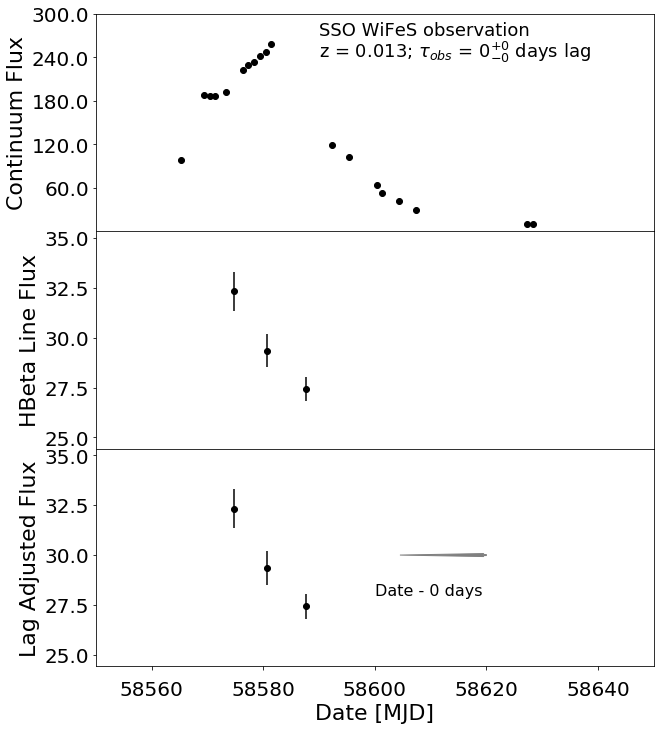

In [34]:
# ---------------------------------- #
# ---------- Light Curves ---------- # Janie's RM dump code
# ---------------------------------- #

#names = ['DES J022828.19-040044.30', 'DES J003352.72-425452.60']
names = ['SSO WiFeS observation']

source = ['20190404']
line, Type, measure, vel, vel_err, mass, lag_us, lag_max_err_us, lag_min_err_us, mass_err_min, mass_err_max = np.loadtxt("output/calibratedandstitched/30apr/3nights_20190401_vel_and_mass.txt",
    dtype={'names':('line','type','measure','Vel', 'vel_err','mass', 'lag', 'lag_err_min', 'lag_err_max', 'mass_err_min','mass_err_max'),
           'formats':('|S100', '|S100','|S100', np.float, np.float, np.float, np.float, np.float, np.float, np.float, np.float)}, skiprows=1,unpack=True)

z_us = [0.0127]#[1.905, 2.593]
for s in range(1):
    date_line, flux_line, err_line = np.loadtxt("output/expt4/" + source[s] + "_Hbeta.txt", unpack=True)
    date_cont, flux_cont, err_cont = np.loadtxt("output/expt4/" + source[s] + "_g.txt", unpack=True)

    lags = '$%s^{+%s}_{-%s}$'%(int(round(lag_us[s],0)),int(round(lag_max_err_us[s],0)),int(round(lag_min_err_us[s],0)))
    title = "SVA1_COADD-" + source[s] + "\nz = " + str(round(z_us[s],3)) + "   lag = " + lags + " days"

    if s == 0:
        fig, ax1, ax2, ax3 = makeFigTriple("", "Date [MJD]", "Continuum Flux",
                                      "HBeta Line Flux","Lag Adjusted Flux", [58550, 58650], [0, 300],
                                           [min(flux_line)-3, max(flux_line)+3], [min(flux_line)-3, max(flux_line)+3])
        fig.set_size_inches(10, 12, forward=True)


    ax1.yaxis.set_major_locator(MaxNLocator(prune='lower'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    ax2.yaxis.set_major_locator(MaxNLocator(prune='upper'))
    ax3.yaxis.set_major_locator(MaxNLocator(prune='upper'))
    ax1.yaxis.major.locator.set_params(nbins=5)
    ax2.yaxis.major.locator.set_params(nbins=5)
    ax2.tick_params(axis='x', pad=10)
    ax3.yaxis.major.locator.set_params(nbins=5)
    ax3.tick_params(axis='x', pad=10)
    ax3.xaxis.major.locator.set_params(nbins=5)

    ax1.errorbar(date_cont, flux_cont, yerr=err_cont, color='black', fmt='o', ms=6, elinewidth=1.5)
    ax2.errorbar(date_line, flux_line, yerr=err_line, color='black', fmt='o', ms=6, elinewidth=1.5)
    ax3.errorbar(date_line-lag_us[s], flux_line, yerr=err_line, color='black', fmt='o', ms=6, elinewidth=1.5)
    if s == 0:
        ax1.text(58590, 270, names[s], fontdict={'color': 'black', 'size': 18})
        ax1.text(58590, 240, "z = " + str(round(z_us[s],3)) + "; " + r'$\tau_{obs}$ = ' + lags + ' days lag', fontdict={'color': 'black', 'size': 18})
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax3.text(58600, 28, 'Date - ' + str(int(round(lag_us[0]))) + ' days', fontdict={'color': 'black', 'size': 16})
        ax3.arrow(58620, 30, -0.5, 0, width=0.05, head_width=0.15, head_length=15, ec='grey', fc='grey')

    plt.savefig('output/expt4/' + source[s] + '_lightCurve.pdf', format='pdf', dpi=1000)
    plt.savefig('output/expt4/' + source[s] + '_lightCurve.png', dpi =600)


    plt.show()